# Operant Data Challenge

Exploration of the call information of agents to debtors, and analysis on how these are affecting the success rates in successfully reclaiming debt.

### Problem Statement
We have created an extension of the data set that describes 55 agents and the 34103 calls that they have placed. Some debtors were called by multiple agents before they repaid or their account was abandoned. Figure out what to suggest to the collection agency, like you would if you work with us. This is purposely an open-ended question so we can see how you would approach the challenge: write a short essay about how you would tackle this challenge and implement a proof-of-concept script and/or visualization using the language and/or tools of your choice. Submit your write-up with any code and/or visualizations on another branch of the same github repository as part 2.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline

In [2]:
#Default Plot Settings
sns.set_style("dark")
sns.set_context('talk')

In [3]:
agents = pd.read_csv('agents.csv')
calls = pd.read_csv('calls.csv')
collections = pd.read_csv('UCI_Credit_Card.csv')
collections.rename(columns = {'default.payment.next.month':'default'}, inplace=True)

In [4]:
agents.head()

,id,name,hire_date,call_centre_id,supervisor_id
0,1000,Steven Lindsey,05-16-11,1,4
1,1001,James Allen,06-02-14,3,8
2,1002,Isaac Luna,06-04-14,1,3
3,1003,Jonathan Sullivan,01-23-14,4,9
4,1004,Lisa Pittman,12-12-14,4,9


In [5]:
calls.head()

,agent_id,debtor_id
0,1000,17
1,1000,19
2,1000,50
3,1000,99
4,1000,145


In [6]:
collections.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [7]:
#Adding an agents column to the Kaggle dataset
debtor_to_agent = {}
for index, row in calls.iterrows():
    debtor_to_agent[row['debtor_id']] = row['agent_id']

agents_list = []
for item in list(collections['ID']):
    try:
        agents_list.append(debtor_to_agent[item])
    except:
        agents_list.append(0)
    
collections['agent'] = agents_list

In [8]:
collections.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default,agent
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1,1032
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1,1050
2,3,90000.0,2,2,2,34,0,0,0,0,...,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0,1014
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0,0


In [9]:
collections = collections[collections.agent != 0]

# Initial Data Exploration and Visualization
Finding some general statistics regarding debtors defaulting based on phone calls that they received from the agents.

In [10]:
#Gathering statistics of the success rates of reclaiming debt based on the agent, call centre, and supervisor id
stats = collections[['default', 'agent']]

agent_to_callcentre = {}
agent_to_name = {}
agent_to_supervisor = {}
for index, row in agents.iterrows():
    agent_to_callcentre[row['id']] = row['call_centre_id']
    agent_to_name[row['id']] = row['name']
    agent_to_supervisor[row['id']] = row['supervisor_id']

callcentres = []
names = []
supervisors = []


for item in list(stats['agent']):
     callcentres.append(agent_to_callcentre[item])
     names.append(agent_to_name[item])
     supervisors.append(agent_to_supervisor[item])
    
stats['call_centre_id'] = callcentres
stats['supervisor_id'] = supervisors
stats['name'] = names

In [11]:
stats.head()

,default,agent,call_centre_id,supervisor_id,name
0,1,1032,1,3,David Roberts
1,1,1050,2,5,David Butler
3,0,1014,3,7,Angela Lara
5,0,1032,1,3,David Roberts
7,0,1053,4,9,Tammy Mosley


Now we have a nice dataframe that we can use to get some general statistics regarding only the agents, call centres, and supervisors.

In [12]:
agent_grouping = stats.groupby('agent', as_index=False)['default'].sum()
counts = stats.groupby('agent').size()
agent_grouping['total'] = list(counts)
agent_grouping['success_ratio'] = 1 - (agent_grouping['default'] / agent_grouping['total'])
names = []
for item in list(agent_grouping['agent']):
    names.append(agent_to_name[item])
agent_grouping['name'] = names


callcentre_grouping = stats.groupby('call_centre_id', as_index=False)['default'].sum()
counts = stats.groupby('call_centre_id').size()
callcentre_grouping['total'] = list(counts)
callcentre_grouping['success_ratio'] = 1 - (callcentre_grouping['default'] / callcentre_grouping['total'])

supervisor_grouping = stats.groupby('supervisor_id', as_index=False)['default'].sum()
counts = stats.groupby('supervisor_id').size()
supervisor_grouping['total'] = list(counts)
supervisor_grouping['success_ratio'] = 1 - (supervisor_grouping['default'] / supervisor_grouping['total'])

In [13]:
agent_grouping.head()

,agent,default,total,success_ratio,name
0,1000,110,275,0.600000,Steven Lindsey
1,1001,52,134,0.611940,James Allen
2,1002,38,147,0.741497,Isaac Luna
3,1003,29,231,0.874459,Jonathan Sullivan
4,1004,30,191,0.842932,Lisa Pittman


In [14]:
callcentre_grouping

,call_centre_id,default,total,success_ratio
0,1,1449,4151,0.650927
1,2,1023,2589,0.604867
2,3,1473,5667,0.740074
3,4,788,8103,0.902752


In [15]:
supervisor_grouping

,supervisor_id,default,total,success_ratio
0,3,589,1826,0.677437
1,4,860,2325,0.630108
2,5,528,1495,0.646823
3,6,495,1094,0.547532
4,7,264,2651,0.900415
5,8,1209,3016,0.599138
6,9,467,3593,0.870025
7,10,321,4510,0.928825


Some visualization of how each of the predictors is influencing the success rate of a debt being collected

In [16]:
#Sorting the agents by success rate
agents_sorted = agent_grouping.sort_values(by='success_ratio', ascending=False)
agents_sorted_amount = agent_grouping.sort_values(by='total', ascending=False)
topten = agents_sorted[0:10]
topten_amount = agents_sorted_amount[0:10]
bottomten = agents_sorted[-11:-1]
bottomten_amount = agents_sorted_amount[-11:-1]

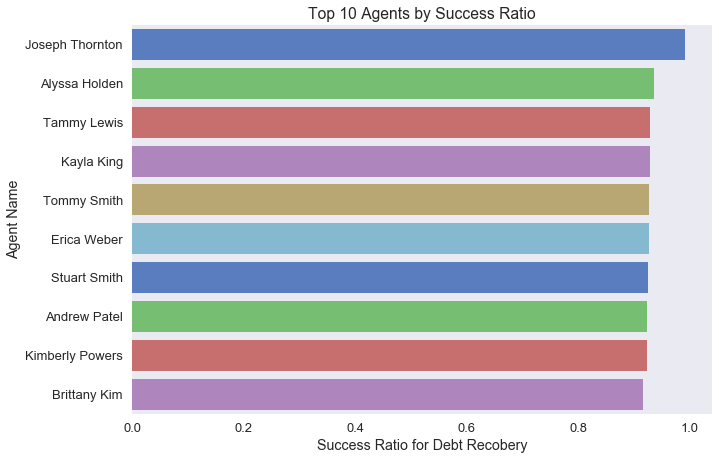

In [17]:
plot = sns.barplot(x=topten.success_ratio, y=topten.name, orient='h', palette='muted')
plot = plot.set(ylabel='Agent Name', xlabel='Success Ratio for Debt Recobery', title='Top 10 Agents by Success Ratio')

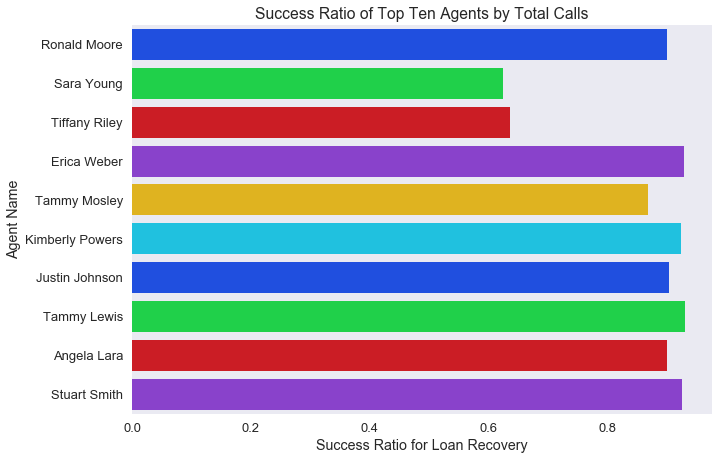

In [18]:
plot = sns.barplot(x=topten_amount.success_ratio, y=topten_amount.name, orient='h', palette='bright')
plot = plot.set(ylabel='Agent Name', xlabel='Success Ratio for Loan Recovery', title='Success Ratio of Top Ten Agents by Total Calls')

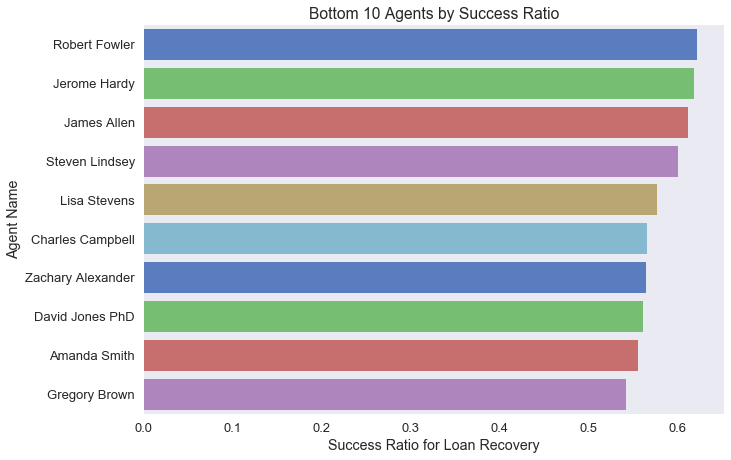

In [19]:
plot = sns.barplot(x=bottomten.success_ratio, y=bottomten.name, orient='h', palette='muted')
plot = plot.set(ylabel='Agent Name', xlabel='Success Ratio for Loan Recovery', title='Bottom 10 Agents by Success Ratio')

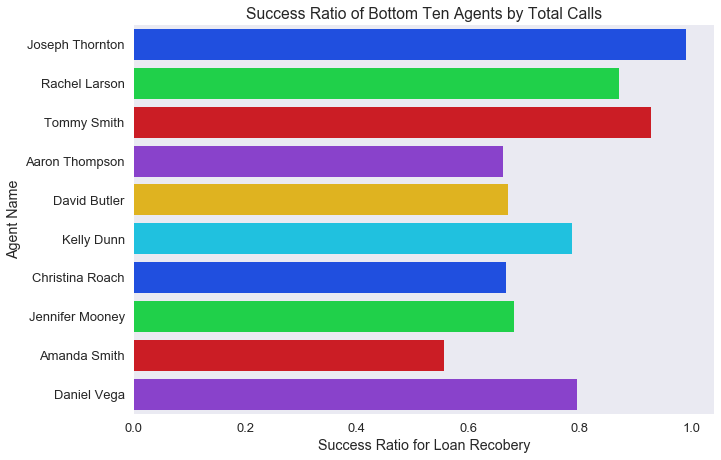

In [20]:
plot = sns.barplot(x=bottomten_amount.success_ratio, y=bottomten_amount.name, orient='h', palette='bright')
plot = plot.set(ylabel='Agent Name', xlabel='Success Ratio for Loan Recobery', title='Success Ratio of Bottom Ten Agents by Total Calls')

In [21]:
#Sorting the call centres and supervisors by success rates
callcentre_sorted = callcentre_grouping.sort_values(by='success_ratio', ascending=False)
callcentre_sorted['call_centre_id'] = callcentre_sorted['call_centre_id'].astype(str)
supervisor_sorted = supervisor_grouping.sort_values(by='success_ratio', ascending=False)
supervisor_sorted['supervisor_id'] = supervisor_sorted['supervisor_id'].astype(str)

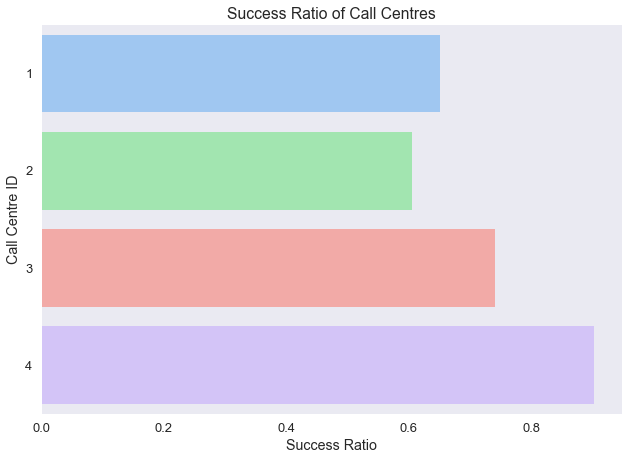

In [22]:
plot = sns.barplot(x=callcentre_sorted.success_ratio, y=callcentre_sorted.call_centre_id, orient='h', palette='pastel')
plot = plot.set(xlabel='Success Ratio', ylabel='Call Centre ID', title='Success Ratio of Call Centres')

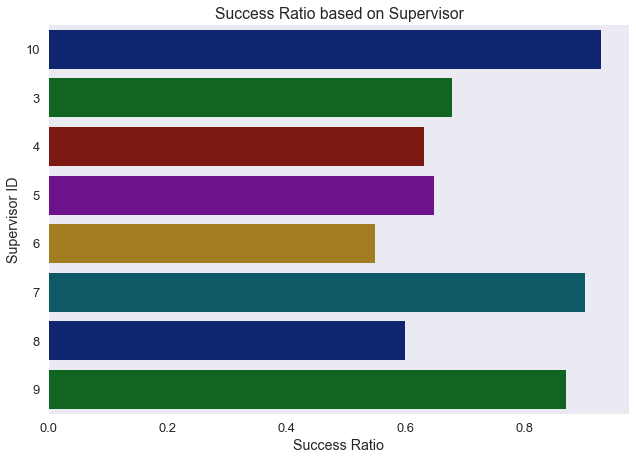

In [23]:
plot = sns.barplot(x=supervisor_sorted.success_ratio, y=supervisor_sorted.supervisor_id, orient='h', palette='dark')
plot = plot.set(xlabel='Success Ratio', ylabel='Supervisor ID', title='Success Ratio based on Supervisor')

# Discussion of Initial Exploration


Through some basic grouping and aggregating, we can sort our agents based on both the total number of debts that they have recovered with their phone calls, as well as their success ratio in recovering debt based on the calls that they've made. 

The success ratio is likely a better indicator of performance than the total number of successful debt recoveries, as we see that many of the agents with the most recovered debts have medicre rations of recovery, and thus the number of debts recovered does not necessarily indicate how well they are performing, as is the case with the agents who have the lowest number of debts recovered.

The agents with the best and worst success ratios should be further analyzed to see what types of practices they undergo and find those in common between the most and least successful performers.

The call centre data shows that call centre four is performing significantly better than the other three call centres, so this should probably be further investigated for any differences between the other call centres that could be causing this.

Also, regarding the supervisor IDs, we can see that agents under supervisors 10, 7, and 9 all have significantly higher success ratios than the rest of the supervisors, so the practices undergone by these supervisors should also be analyzed and compared with the rest of the supervisors to find underlying causes for these, and perhaps investigate the types of practices these supervisors have and if there are any trends between the the most successful or least successful supervisors.

# Feature Level Analysis
Analyzing different features in how much they're influencing a predictive model for if a call will be successful or not.

Just using features from the second dataset.

In [24]:
stats.drop('name', axis=1, inplace=True)

In [25]:
#Converting these to strings so that they're used as categorical data
stats['call_centre_id'] = stats['call_centre_id'].astype(str)
stats['supervisor_id'] = stats['supervisor_id'].astype(str)
stats['agent'] = stats['agent'].astype(str)

In [40]:
stats['seniority'] = df['seniority']

In [41]:
stats.head()

,default,agent,call_centre_id,supervisor_id,seniority
0,1,1032,1,3,0.990046
1,1,1050,2,5,-2.458420
3,0,1014,3,7,1.508826
5,0,1032,1,3,0.990046
7,0,1053,4,9,-0.532538


In [42]:
X_train = stats.drop(['default'], 1)
Y_train = stats['default']

clf = ExtraTreesClassifier()
clf.fit(X_train,Y_train)


importances = list(clf.feature_importances_ )
names = ['Agent', 'Call Centre', 'Supervisor ID', 'Seniority']

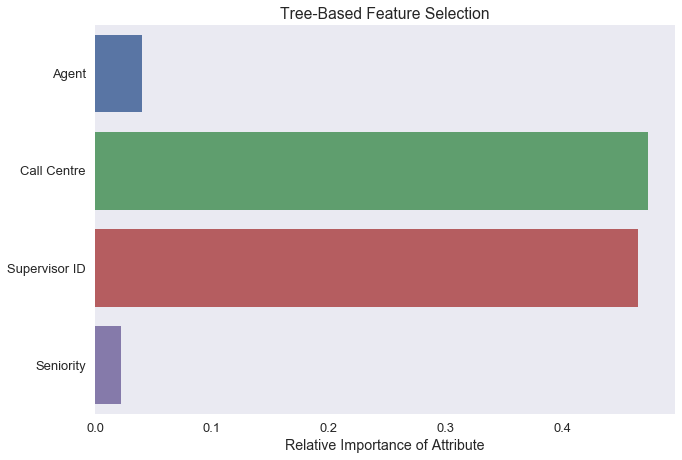

In [43]:
plot = sns.barplot(x=importances, y=names, orient='h')
plot = plot.set(xlabel='Relative Importance of Attribute', title='Tree-Based Feature Selection')

In [26]:
#Gathering and processing the Kaggle dataset, standardizing numeric features and one-hot-encoding categorical features
df = pd.read_csv('UCI_Credit_Card.csv')
df.rename(columns = {'default.payment.next.month':'default'}, inplace=True)
sex = pd.get_dummies(df['SEX'])
sex.columns = ['MALE', 'FEMALE']
marriage = pd.get_dummies(df['MARRIAGE'])
marriage.columns = ['UNKNOWN', 'MARRIED', 'SINGLE', 'OTHER']
label = df['default']
df.drop(df.columns[[0, 2, 4, 24]], axis=1, inplace=True)
df = (df - df.mean()) / df.std()
df['MALE'] = sex['MALE']
df['FEMALE'] = sex['FEMALE']
df['UNKNOWN'] = marriage['UNKNOWN']
df['MARRIED'] = marriage['MARRIED']
df['SINGLE'] = marriage['SINGLE']
df['OTHER'] = marriage['OTHER']

In [27]:
df.head()

,LIMIT_BAL,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,MALE,FEMALE,UNKNOWN,MARRIED,SINGLE,OTHER
0,-1.136701,0.185825,-1.245999,1.794534,1.782318,-0.696652,-0.666588,-1.530021,-1.486016,-0.642490,...,-0.296796,-0.308057,-0.314131,-0.293377,0,1,0,1,0,0
1,-0.365974,0.185825,-1.029030,-0.874977,1.782318,0.138862,0.188743,0.234913,1.992282,-0.659208,...,-0.240001,-0.244226,-0.314131,-0.180875,0,1,0,0,1,0
2,-0.597192,0.185825,-0.161154,0.014860,0.111734,0.138862,0.188743,0.234913,0.253133,-0.298555,...,-0.240001,-0.244226,-0.248679,-0.012122,0,1,0,0,1,0
3,-0.905483,0.185825,0.164300,0.014860,0.111734,0.138862,0.188743,0.234913,0.253133,-0.057490,...,-0.228641,-0.237842,-0.244162,-0.237126,0,1,0,1,0,0
4,-0.905483,0.185825,2.333990,-0.874977,0.111734,-0.696652,0.188743,0.234913,0.253133,-0.578608,...,0.271161,0.266429,-0.269034,-0.255183,1,0,0,1,0,0


In [28]:
#Feature importances of the Kaggle dataset
X_train = df
Y_train = label

clf = ExtraTreesClassifier()
clf.fit(X_train,Y_train)


importances = list(clf.feature_importances_ )
names = list(df)

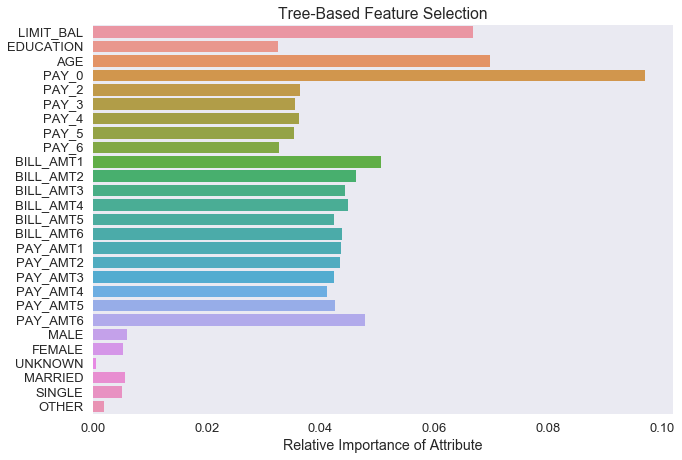

In [29]:
plot = sns.barplot(x=importances, y=names, orient='h')
plot = plot.set(xlabel='Relative Importance of Attribute', title='Tree-Based Feature Selection')

Since the gender and marital status do not seem to have a large influence on predicting whether a customer will default or not,  I'll remove them from the dataset. Next thing I want to see is the comparitive predictive power of the features in the Kaggle dataset to the features regarding the agents, supervisors, hire dates, and call centres. I'm going to make a dataset combining the two, and remove the data which doesn't have an agent in it.

In [30]:
df = df.drop(['MALE', 'FEMALE', 'UNKNOWN', 'MARRIED', 'SINGLE', 'OTHER'], axis=1)

In [31]:
#Combining the Kaggle dataset with the call information dataset
df2 = pd.read_csv('UCI_Credit_Card.csv')
df['ID'] = df2['ID']

debtor_to_agent = {}
agent_to_callcentre = {}
agent_to_supervisor = {}
agent_to_hiredate = {}
for index, row in calls.iterrows():
    debtor_to_agent[row['debtor_id']] = row['agent_id']

for index, row in agents.iterrows():
    agent_to_callcentre[row['id']] = row['call_centre_id']
    agent_to_supervisor[row['id']] = row['supervisor_id']
    agent_to_hiredate[row['id']] = row['hire_date']

agents_list = []


for item in list(df['ID']):
    try:
        agents_list.append(debtor_to_agent[item])
    except:
        agents_list.append(0)
        
df['agent'] = agents_list

callcentre_list = []
supervisor_list = []
hiredate_list = []

for item in list(df['agent']):
    try:
        callcentre_list.append(agent_to_callcentre[item])
    except:
        callcentre_list.append(0)
        
    try:
        supervisor_list.append(agent_to_supervisor[item])
    except:
        supervisor_list.append(0)
        
    try:
        hiredate_list.append(agent_to_hiredate[item])
    except:
        hiredate_list.append(0)

df['call_centre_id'] = callcentre_list
df['supervisor_id'] = supervisor_list
df['hiredate'] = hiredate_list
     
        
 

In [32]:
df = df[df.agent != 0]

In [33]:
#Converting the time since being hired into a feature called seniority, which numerically represents how long the agent has been working
def convert_date(date):
    current_year = 17
    current_day = 20
    current_month = 6
    mdy = date.split('-')
    if mdy[0][0] == 0:
        mdy[0] = int(mdy[0][1])
    if mdy[1][0] == 0:
        mdy[1] = int(mdy[1][1])
    
    year_diff = current_year - int(mdy[2])
    month_diff = current_month - int(mdy[0])
    day_diff = current_day - int(mdy[1])
    
    time_since_hire = 365 * year_diff + 30 * month_diff + day_diff
    return time_since_hire

In [34]:
df['seniority'] = df['hiredate'].map(convert_date)

In [35]:
df.head()

,LIMIT_BAL,EDUCATION,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,...,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,ID,agent,call_centre_id,supervisor_id,hiredate,seniority
0,-1.136701,0.185825,-1.245999,1.794534,1.782318,-0.696652,-0.666588,-1.530021,-1.486016,-0.642490,...,-0.296796,-0.308057,-0.314131,-0.293377,1,1032,1,3,05-21-11,2219
1,-0.365974,0.185825,-1.029030,-0.874977,1.782318,0.138862,0.188743,0.234913,1.992282,-0.659208,...,-0.240001,-0.244226,-0.314131,-0.180875,2,1050,2,5,09-17-16,278
3,-0.905483,0.185825,0.164300,0.014860,0.111734,0.138862,0.188743,0.234913,0.253133,-0.057490,...,-0.228641,-0.237842,-0.244162,-0.237126,4,1014,3,7,08-04-10,2511
5,-0.905483,-1.079439,0.164300,0.014860,0.111734,0.138862,0.188743,0.234913,0.253133,0.178944,...,-0.259482,-0.244226,-0.248679,-0.248376,6,1032,1,3,05-21-11,2219
7,-0.520120,0.185825,-1.354484,0.014860,-0.723558,-0.696652,0.188743,0.234913,-0.616441,-0.534350,...,-0.296796,-0.270971,-0.203713,-0.206638,8,1053,4,9,09-28-13,1362


In [36]:
df['seniority'] =(df['seniority'] - df['seniority'].mean()) / df['seniority'].std()

In [37]:
#Converting these features into categorical features
df = df.drop(['ID', 'hiredate'], axis=1)
df['call_centre_id'] = df['call_centre_id'].astype(str)
df['supervisor_id'] = df['supervisor_id'].astype(str)
df['agent'] = df['agent'].astype(str)

In [38]:
#Feature analysis on the combined dataset
X_train = df
Y_train = collections['default']

clf = ExtraTreesClassifier()
clf.fit(X_train,Y_train)


importances = list(clf.feature_importances_ )
names = list(df)

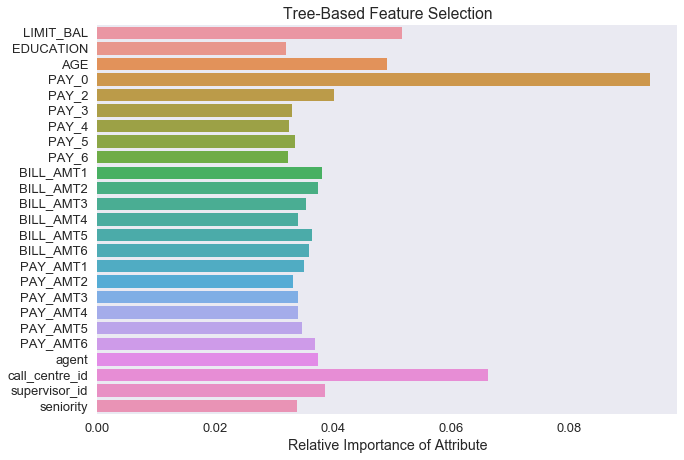

In [39]:
plot = sns.barplot(x=importances, y=names, orient='h')
plot = plot.set(xlabel='Relative Importance of Attribute', title='Tree-Based Feature Selection')

## Correlation Heatmap of Numeric Attributes

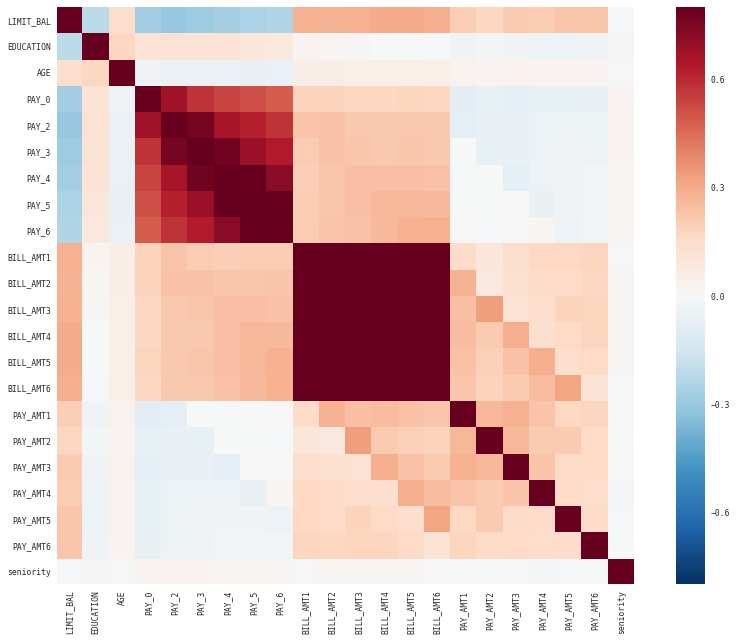

In [44]:
sns.set(context="paper", font="monospace")

corrmat = df.corr()

f, ax = plt.subplots(figsize=(12, 9))

sns.heatmap(corrmat, vmax=.8, square=True)

        
f.tight_layout()

# Feature Analysis Discussion

Based on just the features given regarding the agents, we can see that the call centre and the agents' supervisor tend to be very influencial features when considering predicting whether a call will result in the debt being repayed or not, further reinforcing the need to further investigate what is causing the large discrepancy in success rates of different call centres and agents that are under certain supervisors.

Compared to the other feature information from the Kaggle dataset, information about the agents making calls to them has high importance in its prediction along with the specific information about the debtor.

The correlation between attributes shows that since the PAY and BILL features are highly correlated, perhaps we can do some elimination on those without losing predictive performance.

# Default Predictor Performance Using Agent Data

In [47]:
#Retraining a classifier using the combined dataset to compare with performance on just the Kaggle data
X = df
y = collections['default']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

param_grid = {'n_jobs': [5, 10, 12, 15, 20],
             'n_estimators': [100, 300, 500, 1000]}
model = GridSearchCV(RandomForestClassifier(), param_grid)
model.fit(X_train, y_train)

print('Training accuracy:', model.score(np.array(X_train),np.array(y_train)))
print('Test accuracy:', model.score(np.array(X_test), np.array(y_test)))
print(model.best_params_)

Training accuracy: 1.0
Test accuracy: 0.821982567588
{'n_estimators': 100, 'n_jobs': 5}


# Conclusion

Based on this brief analysis, there is evidently a large variance in the success of the different agents' in reclaiming debts using phone calls. Agents with larger number of total debts reclaimed did not correlate strongly with their success rates in retrieving the debt.

Moreover, there are large discrepancies between the success rates out of different call centres and from agents under different supervisors. 

In considering prediction of debt being defaulted, information about the agents and calls slightly improved predictive performance compared to only using the Kaggle data, but did not improve it by a significant margin. 

## Suggestions
Further analysis and data should be collected on the attributes of the call centres, supervisors, and agents to try and find what are the underlying causes of the success rate discrepancies. Interviews with the top agents, the supervisors with the higher success rate of the agents under them, and analysis of call audio data from the most and least successfull agents, as well as for call centre comparison would likely lead to better insights.

Specifically, call centre 4 seems to be largely outperforming the other call centres, so this might be a start for targetting what the agents in this call centre are doing differently

